# Experiment - Data Preparation Techniques
* StelllarAlgo Data Science
* Ryan Kazmerik, Grant Donst, Peter Morrison
* Dec 02, 2022

In [289]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data_sci_toolkit.aws_tools import redshift_tools
from data_sci_toolkit.common_tools import config_tools

from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport

from pycaret.classification import *

from sklearn.decomposition import PCA

## Let's load in our dataset from Redshift:

In [290]:
# df = redshift_tools.get_product_propensity_dataset(
#     cluster= "prod-app",
#     database= "stlrcanucks",
#     lkupclientid= 7,
#     scoring_year= 2022,
#     type_flag= 0
# )
# df.shape

### Let's choose a smaller set of features for this experiment:

In [291]:
# features = [
#     "atp_last",
#     "attended_last",
#     "distance",
#     "events_last",
#     "spend_current",
#     "sends",
#     "tenure",
#     "opens",
#     "product",
#     "volume_current"
# ]

In [292]:
# df = df[features]
# df.shape

### Let's filter our data to product plans only:

In [293]:
# product_plans = [
#    "Full Season",
#    "Half Season",
#    "Quarter",
#    "Mini Pack"
# ]

In [294]:
# df = df[df["product"].isin(product_plans)].reset_index(drop=True)
# df.shape

In [295]:
#df.to_parquet("./data/data_prep_df.parquet", index=False)
df = pd.read_parquet("./data/data_prep_df.parquet")
df.shape

(15923, 10)

## Let's visualize the dimensionality of our dataset:

In [296]:
#df["product_encoded"] = df["product"].astype("category").cat.codes
#df = df.drop(["product"], axis=1)

In [297]:
#df = df.dropna()

In [298]:
#pca = PCA(n_components=3)
#pca_result = pca.fit_transform(df)

#df['pca-one'] = pca_result[:,0]
#df['pca-two'] = pca_result[:,1] 
#df['pca-three'] = pca_result[:,2]

In [299]:
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
#ax.scatter(
#    xs=df["pca-one"], 
#    ys=df["pca-two"], 
#    zs=df["pca-three"], 
#    c=df["product_encoded"], 
#    cmap='tab10'
#)
#ax.set_xlabel('pca-one')
#ax.set_ylabel('pca-two')
#ax.set_zlabel('pca-three')
#plt.show()

## Let's try imputing some missing values:

In [300]:
df["atp_last"] = df["atp_last"].fillna(method="backfill")

In [301]:
df["attended_last"] = df["attended_last"].fillna(method="backfill")
df["events_last"] = df["events_last"].fillna(method="backfill")

In [302]:
df["opens"] = df["opens"].fillna(method="backfill")
df["sends"] = df["sends"].fillna(method="backfill")

## Let's remove some outliers from our data:

In [303]:
def subset_by_iqr(df, column, whisker_bottom=1.5, whisker_top=1.5):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_bottom*iqr) & (df[column] <= q3 + whisker_top*iqr)
    return df.loc[filter]       

In [304]:
df = subset_by_iqr(df, 'atp_last', 1.0)
df = subset_by_iqr(df, 'spend_current', 1.5, 1.0)
df = subset_by_iqr(df, 'distance', 1.5, 1.5)
df = subset_by_iqr(df, 'opens', 1.5, 1.0)
df = subset_by_iqr(df, 'volume_current', 1.5, 1.0)
df.shape

(11747, 10)

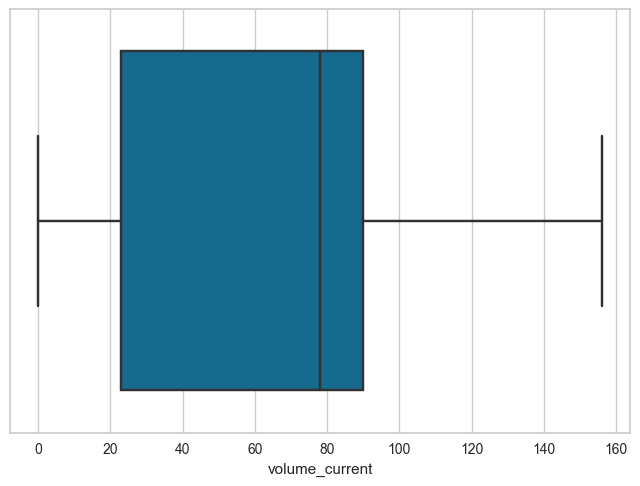

In [305]:
#sns.boxplot(x=df["volume_current"])
#plt.show()

## Let's resample our data using SMOTE to fix class imbalance on our target variable:

In [306]:
df = df.dropna()

In [307]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop(["product"], axis=1), df["product"])

In [308]:
df = X_res
df["product"] = y_res

In [309]:
df.head()

,atp_last,attended_last,distance,events_last,spend_current,sends,tenure,opens,volume_current,product
0,156.59,10.0,5.65,11.0,2021.36,2.0,1,0.0,22,Quarter
1,156.59,10.0,26.41,11.0,2025.00,52.0,4,75.0,8,Full Season
2,116.43,42.0,46.10,44.0,9478.50,90.0,5,95.0,84,Full Season
3,0.00,0.0,6.52,0.0,1293.60,2.0,1,0.0,22,Quarter
4,0.00,0.0,5.04,0.0,2541.00,2.0,1,1.0,44,Quarter


In [310]:
df.shape

(27180, 10)

## Let's check the datatypes infered by Pandas to see if they are correct:

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27180 entries, 0 to 27179
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   atp_last        27180 non-null  float64
 1   attended_last   27180 non-null  float64
 2   distance        27180 non-null  float64
 3   events_last     27180 non-null  float64
 4   spend_current   27180 non-null  float64
 5   sends           27180 non-null  float64
 6   tenure          27180 non-null  int64  
 7   opens           27180 non-null  float64
 8   volume_current  27180 non-null  int64  
 9   product         27180 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 2.1+ MB


## Let's visualize the dimensionality of our dataset:

In [312]:
df["product_encoded"] = df["product"].astype("category").cat.codes
df = df.drop(["product"], axis=1)

In [313]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

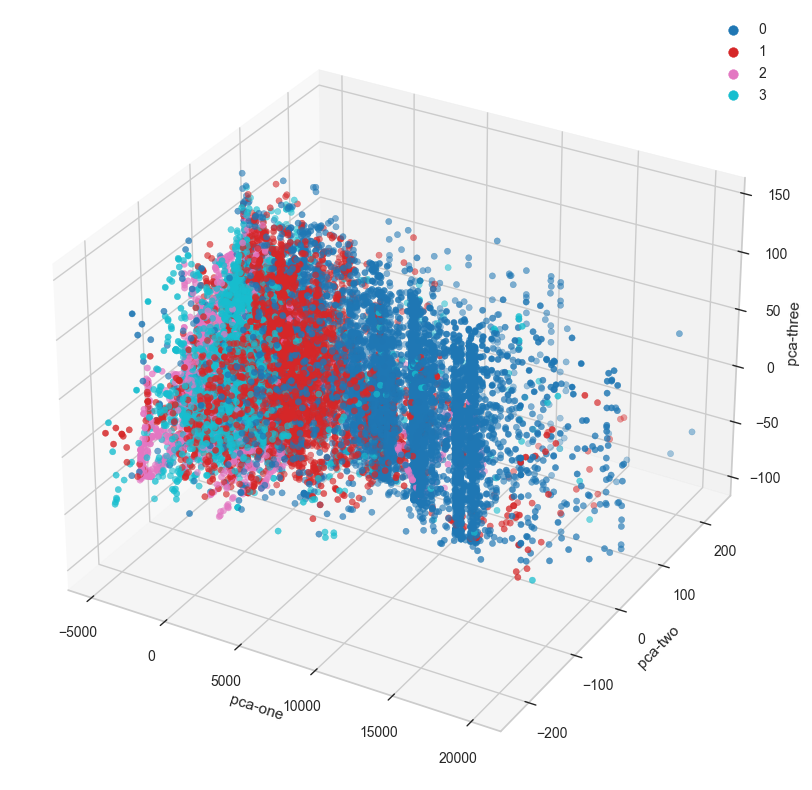

In [314]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
chart = ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["product_encoded"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

ax.legend(*chart.legend_elements())
plt.show()

## Let's run a pandas profile report for our df:

In [315]:
profile = ProfileReport(df)
profile.to_file("pandas-profile-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Done